# PCA with Image Dataset CIFAR-10

Practical Implementation Scenarios:
Edge IoT Devices: For devices with limited processing power and memory, using a full-fledged CNN might not be feasible. Instead, PCA can be used to reduce the data dimensionality before applying a simpler classifier like SVM or Random Forest.

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.  

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.  

The classes are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck  

In [33]:
import tensorflow as tf

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

### Reshape

In [34]:
print(train_images.shape)
print(test_images.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


Since each image in CIFAR-10 is a 3-dimensional array (32x32 pixels with 3 color channels), and PCA requires a 2-dimensional input (samples x features), you will need to reshape the image arrays into vectors. This means converting the 32x32x3 arrays into 3072-length vectors.

In [36]:
# Reshape the training and testing image arrays
train_images_flat = train_images.reshape((train_images.shape[0], -1))
test_images_flat = test_images.reshape((test_images.shape[0], -1))

### Normalize

In [37]:
# Normalize the pixel values to range 0-1
train_images_flat = train_images_flat.astype('float32') / 255
test_images_flat = test_images_flat.astype('float32') / 255

# Check shapes and data ranges
print("Training images shape:", train_images_flat.shape)
print("Test images shape:", test_images_flat.shape)
print("Min and max pixel values:", train_images_flat.min(), train_images_flat.max())

Training images shape: (50000, 3072)
Test images shape: (10000, 3072)
Min and max pixel values: 0.0 1.0


### Principal Component Analysis

In [38]:
from sklearn.decomposition import PCA

# Initialize PCA, choose 95% variance
pca = PCA(n_components=0.95)

# Fit PCA on the training data
pca.fit(train_images_flat)

# Transform both the training and testing data
train_images_pca = pca.transform(train_images_flat)
test_images_pca = pca.transform(test_images_flat)

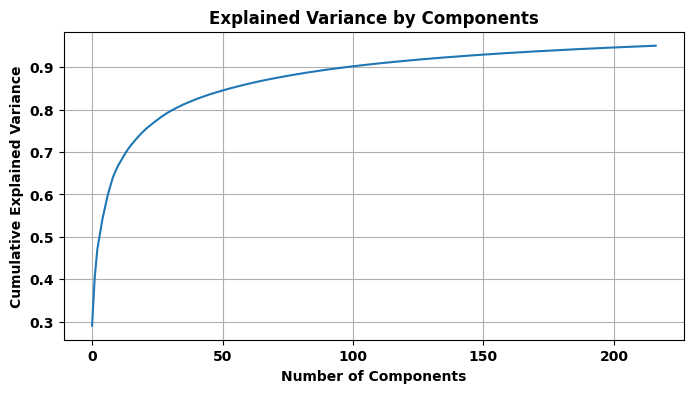

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the explained variance
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.grid(True)
plt.show()


In [40]:
pca.n_components_

217

View photo quality

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


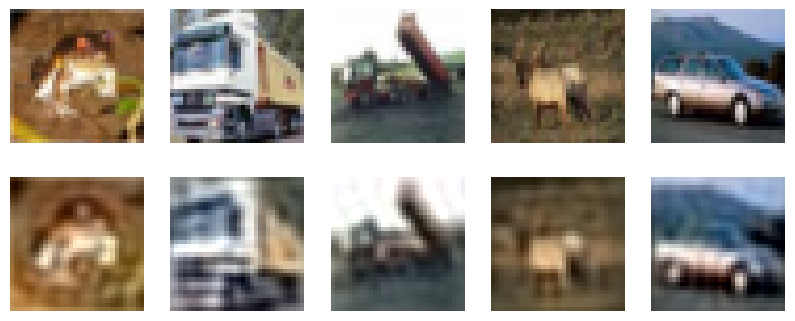

In [41]:
import matplotlib.pyplot as plt

train_images_pca = pca.fit_transform(train_images_flat)
train_images_reconstructed = pca.inverse_transform(train_images_pca)
train_images_reconstructed = train_images_reconstructed.reshape((train_images.shape[0], 32, 32, 3))

def plot_images(original, reconstructed, n=5):
    plt.figure(figsize=(10, 4))
    for i in range(n):
        # Plot original images
        plt.subplot(2, n, i + 1)
        plt.imshow(original[i])
        plt.axis('off')
        
        # Plot reconstructed images
        plt.subplot(2, n, n + i + 1)
        plt.imshow(reconstructed[i])
        plt.axis('off')
    plt.show()

plot_images(train_images[:5], train_images_reconstructed[:5])


### Modeling
Build ML models for the original dataset.  

Split the data

In [113]:
from sklearn.model_selection import train_test_split
# original data
X_train, X_validate, y_train, y_validate = train_test_split(
    train_images_flat, train_labels.flatten(), test_size=0.2, random_state=42
)
# PCA reduced data
X_train_pca, X_validate_pca, y_train_pca, y_validate_pca = train_test_split(
    train_images_pca, train_labels.flatten(), test_size=0.2, random_state=42
)

SVM Model

In [120]:
from sklearn.svm import SVC

model_svm = SVC(kernel='rbf', C=1.0, gamma='scale')
model_svm.fit(X_train, y_train)

svm_model_PCA = SVC(kernel='rbf', C=1.0, gamma='scale')
svm_model_PCA.fit(X_train_pca, y_train_pca)

SVC()

In [122]:
import pickle

# with open('../model/svm.pkl', 'wb') as file:
#     pickle.dump(model_svm, file)
# with open('model/svm.pkl', 'wb') as file:
#     pickle.dump(model_svm, file)
    
with open('../model/svm_pca.pkl', 'wb') as file:
    pickle.dump(svm_model_PCA, file)
with open('model/svm_pca.pkl', 'wb') as file:
    pickle.dump(svm_model_PCA, file)

Import models

In [119]:
import pickle

path_svm = '../model/svm.pkl'
path_svm_PCA = '../model/svm_PCA.pkl'
with open(path_svm, 'rb') as file:
    model_SVM_load = pickle.load(file)
with open(path_svm_PCA, 'rb') as file:
    model_SVM_PCA_load = pickle.load(file)

Investigate overfitting

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(model_history):
    '''
    Function to plot training and validation loss
    '''
    plt.figure(figsize=(12, 5))

    ax1 = plt.subplot(1, 2, 1)
    ax1.plot(model_history.history['loss'], label='Training Loss')
    ax1.plot(model_history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    # Plotting training and validation accuracy
    ax2 = plt.subplot(1, 2, 2)
    ax2.plot(model_history.history['accuracy'], label='Training Accuracy')
    ax2.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.show()

Compare performance

In [23]:
from sklearn.metrics import accuracy_score

# original model
accuracy_orig_svm = accuracy_score(y_validate, model_svm.predict(X_validate))
# PCA model
accuracy_pca_svm = accuracy_score(y_validate_pca, model_svm_pca.predict(X_validate_pca))


print("SVM")
print("Accuracy on original data:", accuracy_orig_svm)
print("Accuracy on PCA-reduced data:", accuracy_pca_svm)


Decision Tree
Accuracy on original data: 0.2577
Accuracy on PCA-reduced data: 0.2457
Random Forest
Accuracy on original data: 0.4804
Accuracy on PCA-reduced data: 0.4808
SVM
Accuracy on original data: 0.5321
Accuracy on PCA-reduced data: 0.5307


### Convolutional Neural Network (CNN)

In this example model a total of 9 layers such as Input, Conv2D, MaxPooling2D, Flatten, Dense . Every layer has its own hyper-parameters. Sequential operation

In [80]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.astype("float32") / 255                                     
X_test = X_test.astype("float32") / 255

X_train, X_validate, y_train, y_validate = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)


In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense

model_cnn = Sequential([
    Input(shape=(32, 32, 3)),
    Conv2D(32, 3, padding='valid', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(128, 3, activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.50),
    Dense(10, activation='softmax'),
])


# model_cnn.summary()  

# from keras.utils import plot_model
# plot_model(model, to_file = 'model.png')

model_cnn.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits = False),     
    optimizer = keras.optimizers.Adam(learning_rate=3e-4),                               
    metrics =["accuracy"],                                                       
)

history_cnn = model_cnn.fit(X_train, y_train, 
                            batch_size = 64, 
                            epochs = 20,
                            verbose = 2,
                            validation_data=(X_validate, y_validate)) 
plot_losses(history_cnn)

In [93]:
model_cnn.save('../model/cnn.keras')
model_cnn.save('model/cnn.keras')

### Evaluate test data

In [ ]:
import time
import numpy as np
import tensorflow as tf

def evaluate_prediction_time(model, X_test):
    '''
    Function to evaluate prediction time
    '''
    start_time = time.time()
    predictions = model.predict(X_test)
    end_time = time.time()
    total_time = end_time - start_time
    average_time_per_image = total_time / len(X_test)
    print(f"Total time to process {len(X_test)} images: {total_time} seconds")
    # print(f"Average prediction time per image: {average_time_per_image} seconds")

CNN

In [89]:
# Assuming test_images and test_labels are your test datasets
test_loss, test_accuracy = model_cnn.evaluate(X_test, y_test, verbose=2)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
evaluate_prediction_time(model_cnn, X_test)

313/313 - 1s - 4ms/step - accuracy: 0.6036 - loss: 1.1064
Test Loss: 1.1063889265060425
Test Accuracy: 0.603600025177002


SVM

In [111]:
from tensorflow.keras.models import load_model
model_dnn_pca = load_model('../model/svm.keras')

evaluate_prediction_time(model_dnn_pca, X_test_pca)

MemoryError: Unable to allocate 29.8 GiB for an array with shape (400000000, 10) and data type float64

SVM PCA

In [ ]:
model_dnn_pca = load_model('../model/svm_pca.pkl')

evaluate_prediction_time(model_dnn_pca, X_test)